In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('Employee.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  140 non-null    object 
 1   Age      130 non-null    float64
 2   Salary   124 non-null    float64
 3   Place    134 non-null    object 
 4   Country  148 non-null    object 
 5   Gender   148 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 7.1+ KB


In [25]:
df.describe()

,Age,Salary,Gender
count,130.000000,124.000000,148.000000
mean,30.484615,5312.467742,0.222973
std,11.096640,2573.764683,0.417654
min,0.000000,1089.000000,0.000000
25%,22.000000,3030.000000,0.000000
50%,32.500000,5000.000000,0.000000
75%,37.750000,8000.000000,0.000000
max,54.000000,9876.000000,1.000000


In [26]:
df

,Company,Age,Salary,Place,Country,Gender
0,TCS,20.0,NaN,Chennai,India,0
1,Infosys,30.0,NaN,Mumbai,India,0
2,TCS,35.0,2300.0,Calcutta,India,0
3,Infosys,40.0,3000.0,Delhi,India,0
4,TCS,23.0,4000.0,Mumbai,India,0
...,...,...,...,...,...,...
143,TCS,33.0,9024.0,Calcutta,India,1
144,Infosys,22.0,8787.0,Calcutta,India,1
145,Infosys,44.0,4034.0,Delhi,India,1
146,TCS,33.0,5034.0,Mumbai,India,1


In [27]:
print('\n\n### 1) Data Exploration')
for col in df.columns:
    uniques = df[col].unique()
    print(f"\nColumn: {col}")
    print(f"dtype: {df[col].dtype}")
    print(f"unique: {df[col].nunique(dropna=False)}")
    print(f"unique sample (up to 10): {uniques[:10]}")



### 1) Data Exploration

Column: Company
dtype: object
unique: 7
unique sample (up to 10): ['TCS' 'Infosys' 'CTS' nan 'Tata Consultancy Services' 'Congnizant'
 'Infosys Pvt Lmt']

Column: Age
dtype: float64
unique: 30
unique sample (up to 10): [20. 30. 35. 40. 23. nan 34. 45. 18. 22.]

Column: Salary
dtype: float64
unique: 41
unique sample (up to 10): [  nan 2300. 3000. 4000. 5000. 6000. 7000. 8000. 9000. 1089.]

Column: Place
dtype: object
unique: 12
unique sample (up to 10): ['Chennai' 'Mumbai' 'Calcutta' 'Delhi' 'Podicherry' 'Cochin' nan 'Noida'
 'Hyderabad' 'Bhopal']

Column: Country
dtype: object
unique: 1
unique sample (up to 10): ['India']

Column: Gender
dtype: int64
unique: 2
unique sample (up to 10): [0 1]


In [28]:
# Renaming columns: make them lower-case and strip spaces for consistency
print('\nRenaming columns to lowercase and removing spaces...')
old_columns = df.columns.tolist()
new_columns = [c.strip().lower().replace(' ', '_') for c in old_columns]
df.columns = new_columns
print("old columns:",old_columns)
print('Columns after renaming:', df.columns.tolist())


Renaming columns to lowercase and removing spaces...
old columns: ['Company', 'Age', 'Salary', 'Place', 'Country', 'Gender']
Columns after renaming: ['company', 'age', 'salary', 'place', 'country', 'gender']


In [29]:
print('\nNumeric summary:')
print(df.describe())


Numeric summary:
              age       salary      gender
count  130.000000   124.000000  148.000000
mean    30.484615  5312.467742    0.222973
std     11.096640  2573.764683    0.417654
min      0.000000  1089.000000    0.000000
25%     22.000000  3030.000000    0.000000
50%     32.500000  5000.000000    0.000000
75%     37.750000  8000.000000    0.000000
max     54.000000  9876.000000    1.000000


In [30]:
print('\n\n### 2) Data Cleaning')
# Replace 0 in age as NaN (as requested) 
if 'age' in df.columns:
    n_zero_age = (df['age'] == 0).sum()
    print(f"Found {n_zero_age} rows where age == 0. Replacing with NaN...")
    df.loc[df['age'] == 0, 'age'] = np.nan



### 2) Data Cleaning
Found 6 rows where age == 0. Replacing with NaN...


In [31]:
# Count missing values per column
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
company     8
age        24
salary     24
place      14
country     0
gender      0
dtype: int64


In [32]:
#  Remove duplicate rows
dups = df.duplicated().sum()
print(f"\nDuplicate rows found: {dups}")
if dups > 0:
    df = df.drop_duplicates()
print("Dropped duplicates. New shape:", df.shape)


Duplicate rows found: 4
Dropped duplicates. New shape: (144, 6)


In [33]:
#  Inappropriate values: example - negative salaries or absurd ages
if 'salary' in df.columns:
    bad_salary = df[df['salary'] < 0]
    print(f"\nRows with salary < 0: {len(bad_salary)}")


Rows with salary < 0: 0


In [34]:
# Outlier detection using IQR for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns detected for outlier detection:', numeric_cols)
outlier_info = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_info[col] = {'lower': lower, 'upper': upper, 'count': outliers.shape[0]}


print('\nOutlier summary (IQR method):')
for k,v in outlier_info.items():
    print(f" - {k}: lower={v['lower']}, upper={v['upper']}, outlier_count={v['count']}")


Numeric columns detected for outlier detection: ['age', 'salary', 'gender']

Outlier summary (IQR method):
 - age: lower=-2.5, upper=65.5, outlier_count=0
 - salary: lower=-4425.0, upper=15455.0, outlier_count=0
 - gender: lower=0.0, upper=0.0, outlier_count=32


In [35]:
print(df.isnull().sum())

company     8
age        23
salary     23
place      14
country     0
gender      0
dtype: int64


In [36]:
# treat missing values
#Fill numeric with median, categorical with mode (recommended balance)
clean_fill = df.copy()
# numeric imputer (median)
num_cols = clean_fill.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = clean_fill.select_dtypes(include=['object', 'category']).columns.tolist()

if len(num_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    clean_fill[num_cols] = num_imputer.fit_transform(clean_fill[num_cols])

if len(cat_cols) > 0:
# mode imputation per column
    for c in cat_cols:
        mode_val = clean_fill[c].mode(dropna=True)
        if not mode_val.empty:
            clean_fill[c] = clean_fill[c].fillna(mode_val.iloc[0])
        else:
            clean_fill[c] = clean_fill[c].fillna('Unknown')

print('Shape after median/mode imputation:', clean_fill.shape)
print('Missing values now:\n', clean_fill.isna().sum())

# Save cleaned version for downstream steps
df_clean = clean_fill.copy()
df=df_clean

Shape after median/mode imputation: (144, 6)
Missing values now:
 company    0
age        0
salary     0
place      0
country    0
gender     0
dtype: int64




### 3) Data Analysis
Filtered rows (age>40 & salary<5000): 15


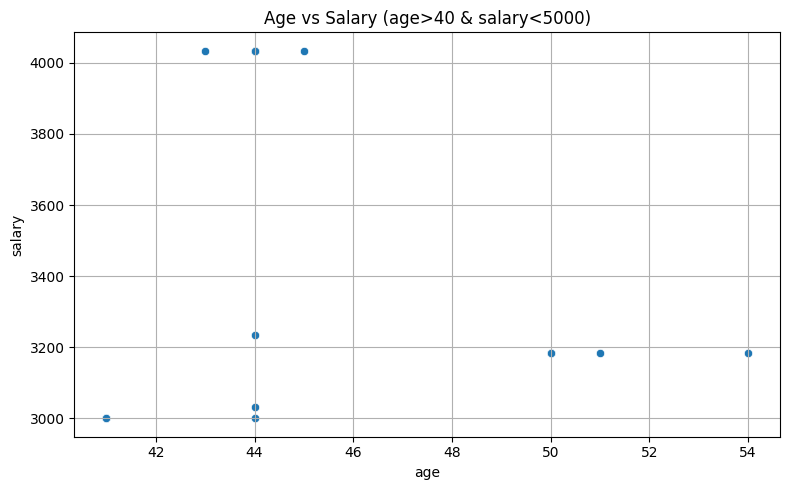


People count by place:
 place
Mumbai        48
Calcutta      32
Chennai       14
Delhi         14
Cochin        13
Noida          8
Hyderabad      8
Podicherry     3
Pune           2
Bhopal         1
Nagpur         1
Name: count, dtype: int64


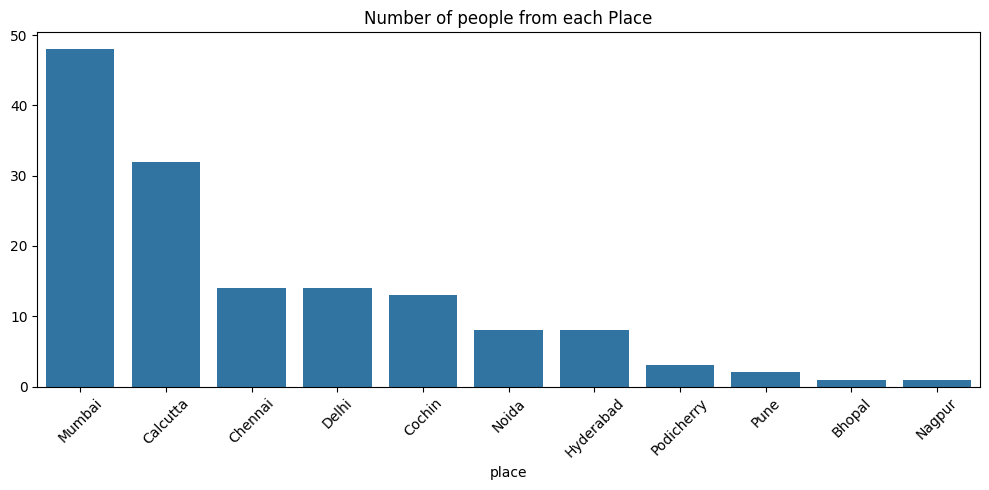

In [37]:
# - Filter data age >40 and salary <5000; plot age vs salary
# - Count number of people from each place and visualize
# ==================================================


print('\n\n### 3) Data Analysis')
if 'age' in df_clean.columns and 'salary' in df_clean.columns:
    filt = df_clean[(df_clean['age'] > 40) & (df_clean['salary'] < 5000)]
    print('Filtered rows (age>40 & salary<5000):', filt.shape[0])
# Plot
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=filt, x='age', y='salary')
    plt.title('Age vs Salary (age>40 & salary<5000)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('Age or Salary not found in columns')


# Count people from each place
if 'place' in df_clean.columns:
    place_counts = df_clean['place'].value_counts()
    print('\nPeople count by place:\n', place_counts)
    plt.figure(figsize=(10,5))
    sns.barplot(x=place_counts.index, y=place_counts.values)
    plt.title('Number of people from each Place')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [38]:
# Data Encoding 
# - Convert categorical variables into numerical using appropriate encoders
# ==================================================

print('\n\n### 4) Data Encoding')
# Identify categorical columns
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical columns:', cat_cols)

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# onehotencoding
df["country"]=pd.get_dummies(df["country"],dtype=int)

# LabelEncoder
le=LabelEncoder()
df["company"]=le.fit_transform(df["company"])
df["place"]=le.fit_transform(df["place"])



### 4) Data Encoding
Categorical columns: ['company', 'place', 'country']


In [21]:
df

,company,age,salary,place,country,gender
0,4,20.0,5000.0,2,1,0.0
1,2,30.0,5000.0,6,1,0.0
2,4,35.0,2300.0,1,1,0.0
3,2,40.0,3000.0,4,1,0.0
4,4,23.0,4000.0,6,1,0.0
...,...,...,...,...,...,...
142,3,22.0,8202.0,6,1,0.0
143,4,33.0,9024.0,1,1,1.0
145,2,44.0,4034.0,4,1,1.0
146,4,33.0,5034.0,6,1,1.0


In [39]:
#5. Feature Scaling 
# - After encoding, perform scaling with StandardScaler and MinMaxScaler
# ==================================================

print('\n\n### 5) Feature Scaling')
# Separate features (X) and potential target (no target given in project; but we scale all numeric features)
X =df.copy()

# Keep a copy before scaling
X_before_scaling = X.copy()

# Standard Scaler
std_scaler = StandardScaler()
X_std = X.copy()
num_features = X_std.select_dtypes(include=[np.number]).columns.tolist()
X_std[num_features] = std_scaler.fit_transform(X_std[num_features])

# MinMax Scaler
mm_scaler = MinMaxScaler()
X_mm = X.copy()
X_mm[num_features] = mm_scaler.fit_transform(X_mm[num_features])

print('Sample after StandardScaler (first 5 rows):')
print(X_std.head())
print('\nSample after MinMaxScaler (first 5 rows):')
print(X_mm.head())



### 5) Feature Scaling
Sample after StandardScaler (first 5 rows):
    company       age    salary     place  country    gender
0  0.991489 -1.484676 -0.100827 -0.893255      0.0 -0.534522
1 -0.239325 -0.267174 -0.100827  0.750562      0.0 -0.534522
2  0.991489  0.341577 -1.243735 -1.304209      0.0 -0.534522
3 -0.239325  0.950328 -0.947426 -0.071346      0.0 -0.534522
4  0.991489 -1.119426 -0.524127  0.750562      0.0 -0.534522

Sample after MinMaxScaler (first 5 rows):
   company       age    salary  place  country  gender
0      0.8  0.081081  0.445089    0.2      0.0     0.0
1      0.4  0.351351  0.445089    0.6      0.0     0.0
2      0.8  0.486486  0.137817    0.1      0.0     0.0
3      0.4  0.621622  0.217480    0.4      0.0     0.0
4      0.8  0.162162  0.331285    0.6      0.0     0.0
